In [1]:
# for data cleaning and analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from zipfile import ZipFile

# for modelling
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings('ignore')

In [2]:
# unzip the data zip file
ZIP_PATH = 'predict-viral-instagram-posts-advanced.zip' # zip file's path
with ZipFile(ZIP_PATH, 'r') as zipObj:
   zipObj.extractall()

In [4]:
# read in files
df_metadata = pd.read_csv('metadata.csv')
df_train = pd.read_csv('train_advance.csv')
df_test = pd.read_csv('test_advance.csv')

In [5]:
df_metadata

,Field,Description
0,SID,Sequence ID
1,ID,Instagrams ID for that could be used on the we...
2,Name,Locations Name
3,Streen,"Streed Address, may contain '\n'"
4,ZIP,Zip code
5,City,City Name
6,Region,Region
7,CD,Country Code
8,Phone,The phone in format as on the Instragram
9,aj_exact_city_match,The Instagrams Internal key


## Train dataset

### Data cleaning

In [7]:
df_train.head()

,Unnamed: 0.1,Unnamed: 0,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,11420,11755,340283947,829324748,28919418,295070,Bka_6xunYma,1,Cheers to wine O‚Äôclock ü•Ç (üì∏: @aob1085),4985,...,NaN,ES,+34 936 65 77 41,False,False,NaN,El Prat de Llobregat,Spain,2,41
1,24264,24967,2631322,199074048,42114489,4342099,BxaZS4fA_nV,1,#malcapuyaisland #bananaisland #bulogisland,57,...,NaN,PH,NaN,True,False,NaN,Coron,Philippines,120,11
2,16286,16768,668571209,3280121227,19193237,2554203,BxmEzQUFocM,1,üî∏\\nSchwarzkehlchen (Saxicola rubicola) ‚Ä¢...,1576,...,Saxony-Anhalt,DE,NaN,False,True,NaN,NaN,NaN,11,51
3,11139,11467,238461670,5625643374,11733129,3465973,Bjq5KFGlJvM,1,Eared Grebe spotted at one of my favourite spo...,29,...,NaN,CA,NaN,True,False,NaN,NaN,NaN,-118,52
4,27320,28111,1005642734,1557071010,8540244,3541402,BweviowATmj,1,–ü–õ–ê–ö–ê–¢–¨ –í –ú–û–°–¢–ê–• - –≠–¢–û –ù–û–†...,1487,...,NaN,RU,79214201362,False,False,—Ü–µ–Ω—Ç—Ä –∏–Ω–∏—Ü–∏–∞—Ü–∏–∏ —Ç–≤–æ—Ä—á–µ—Å—Ç...,Aptekarskiy,Russia,30,59


In [8]:
# examine the shape of train dataframe
df_train.shape

(22924, 31)

In [11]:
# examine all column names
df_train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'location_id', 'profile_id', 'sid',
       'sid_profile', 'post_id', 'post_type', 'description', 'numbr_likes',
       'number_comments', 'profile_name', 'firstname_lastname', 'following',
       'followers', 'n_posts', 'url', 'is_business_account', 'name', 'zip',
       'city', 'region', 'cd', 'phone', 'aj_exact_city_match',
       'aj_exact_country_match', 'blurb', 'dir_city_name', 'dir_country_name',
       'lat', 'lng'],
      dtype='object')

In [23]:
# drop the first two unnamed columns
df_train = df_train[[col for col in df_train.columns[2:]]]
df_train.head()

,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,number_comments,profile_name,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,340283947,829324748,28919418,295070,Bka_6xunYma,1,Cheers to wine O‚Äôclock ü•Ç (üì∏: @aob1085),4985,78,oprahmagazine,...,NaN,ES,+34 936 65 77 41,False,False,NaN,El Prat de Llobregat,Spain,2,41
1,2631322,199074048,42114489,4342099,BxaZS4fA_nV,1,#malcapuyaisland #bananaisland #bulogisland,57,2,jpadi_33,...,NaN,PH,NaN,True,False,NaN,Coron,Philippines,120,11
2,668571209,3280121227,19193237,2554203,BxmEzQUFocM,1,üî∏\\nSchwarzkehlchen (Saxicola rubicola) ‚Ä¢...,1576,15,m4r10_p13ch4ty,...,Saxony-Anhalt,DE,NaN,False,True,NaN,NaN,NaN,11,51
3,238461670,5625643374,11733129,3465973,Bjq5KFGlJvM,1,Eared Grebe spotted at one of my favourite spo...,29,5,vagabondesi,...,NaN,CA,NaN,True,False,NaN,NaN,NaN,-118,52
4,1005642734,1557071010,8540244,3541402,BweviowATmj,1,–ü–õ–ê–ö–ê–¢–¨ –í –ú–û–°–¢–ê–• - –≠–¢–û –ù–û–†...,1487,11,elena__mirra,...,NaN,RU,79214201362,False,False,—Ü–µ–Ω—Ç—Ä –∏–Ω–∏—Ü–∏–∞—Ü–∏–∏ —Ç–≤–æ—Ä—á–µ—Å—Ç...,Aptekarskiy,Russia,30,59


In [24]:
# check for duplicated rows
df_train[df_train.duplicated()]

,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,number_comments,profile_name,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
3275,48155,13020967320,39216808,3872873,BxSwqIaHG87,1,Diagon Ally,4,0,stefspitzig,...,NaN,GB,+44 1904 652915,False,False,NaN,NaN,NaN,-1,53
4313,252754719,10136621406,26969150,3304646,Bx_x-7UHaM6,2,NaN,0,0,iuranirones,...,NaN,MD,NaN,False,False,NaN,NaN,NaN,29,47
5085,287799875168712,10673102630,14225612,3593302,BxHsFWgn3Ra,2,NaN,2,0,q3pk7jyz,...,NaN,US,(305) 918-4040,False,False,NaN,NaN,NaN,-80,25
5242,228449875,10121739155,40330392,4032830,By8ZQa8iXQX,1,–ó–∞–∫–∞—Ç –Ω–∞–¥ –ü–µ—Ä—Ç–æ–∑–µ—Ä–æ–º,3,1,elenasorokina624,...,Republic of Karelia,RU,NaN,False,True,NaN,Shukogora,Russia,33,63
5430,607036219,1578979708,10983296,2497063,Bd_63ughbMj,1,NATURAL ADVANCED BASE YG BERASASKAN AQUA YANG ...,1,0,leezabeauty_,...,Kuala Lumpur,MY,NaN,False,True,NaN,Kuala Lumpur,Malaysia,101,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22203,231262554313921,11473585979,8442382,3204481,BxGuKM_Hu2C,1,üòç extensive star major extensive üòÑ P...,0,0,uylkfonx,...,NaN,US,(305) 769-0274,False,False,NaN,NaN,NaN,-80,25
22225,55898,373092065,14697872,373564,BxOgzXsh-D4,1,NaN,4,0,eviechevy11,...,NaN,US,(212) 995-0333,False,False,NYC's original billiards club located in the h...,NaN,NaN,-73,40
22368,125019806,7947008573,43015191,4467442,BxUV7UNAUN-,1,2011,3,0,vladislavlishtvan2004,...,NaN,RU,NaN,True,False,NaN,K√§kisalmi,Russia,30,61
22381,214395308,3204686307,22726704,2893562,BVb_Ka2hAgD,1,Love this #NewNESTEA Slightly Sweet tea! #Free...,4,0,essentiallybellalove,...,NaN,US,NaN,True,False,NaN,Arcadia,United States,-118,34


There are 99 duplicated rows. These will be removed from the dataframe.

In [25]:
# drop duplicated rows and check the updated dataframe shape
df_train.drop_duplicates(inplace=True)
df_train.shape

/tmp/ipykernel_144/2924915140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop_duplicates(inplace=True)


(22825, 29)

In [27]:
df_train.sid.nunique()

22825

The number of unique `sid` values is the same as the total number of rows, which means `sid` is unique for each row and can be used as the index column.

Based on the metadata, several predictors which could be useful for the prediction are shortlisted:
- `sid` (as the index column)
- `post_type`
- `number_comments`
- `following`
- `followers`
- `n_posts`
- `is_business_account`
- `lat`
- `lng`

In [36]:
# keep relevant variables and use sid as the index column
predictors = ['sid', 'post_type', 'number_comments', 'following', 'followers', 'n_posts', 'is_business_account', 'lat', 'lng', 'numbr_likes']
df_train = df_train[[col for col in predictors]]
df_train.set_index('sid', inplace=True)
df_train.head()

,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
sid,,,,,,,,,
28919418,1,78,420,594895,3612.0,True,2,41,4985
42114489,1,2,486,428,95.0,False,120,11,57
19193237,1,15,5378,36618,1259.0,True,11,51,1576
11733129,1,5,62,126,39.0,False,-118,52,29
8540244,1,11,544,45450,1251.0,True,30,59,1487


In [37]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22825 entries, 28919418 to 5740023
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   post_type            22825 non-null  int64  
 1   number_comments      22825 non-null  int64  
 2   following            22825 non-null  object 
 3   followers            22825 non-null  int64  
 4   n_posts              22820 non-null  float64
 5   is_business_account  22820 non-null  object 
 6   lat                  22825 non-null  int64  
 7   lng                  22825 non-null  int64  
 8   numbr_likes          22825 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 1.7+ MB


Some columns are not in the correct data type, so conversion will be performed.

In [39]:
# convert the data type of the following column
df_train['following'] = pd.to_numeric(df_train['following'])

ValueError: Unable to parse string "2019-08-17 19:53:49.795000" at position 3534

In [44]:
# check rows with invalid values in following column
df_train.loc[df_train['following'].str.contains(r'\D')]

,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
sid,,,,,,,,,
9741848,1,33,2019-05-09 06:30:16.633000,0,NaN,NaN,-2,53,1935
40230055,1,13,2019-07-16 12:32:59.400000,1,NaN,NaN,0,51,1225
3854721,1,1,2019-03-26 23:58:10.746000,0,NaN,NaN,-118,33,84
21058071,1,30,2019-05-09 06:30:16.633000,0,NaN,NaN,-89,21,3632


When trying to parse the `following` column to integer, a ValueError is raised, which brought to attention invalid values in the column. By further examination, these rows might be invalid as there are two null values. Since there are just very few rows, they will be removed.

In [45]:
# drop the invalid rows
df_train.drop(df_train.index[df_train['following'].str.contains(r'\D')], inplace = True)

In [46]:
# convert columns to the correct data types
df_train['following'] = pd.to_numeric(df_train['following'])
df_train['n_posts'] = df_train['n_posts'].astype(int)
df_train['is_business_account'] = df_train['is_business_account'].replace({True: 1, False: 0})

df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22820 entries, 28919418 to 5740023
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   post_type            22820 non-null  int64
 1   number_comments      22820 non-null  int64
 2   following            22820 non-null  int64
 3   followers            22820 non-null  int64
 4   n_posts              22820 non-null  int64
 5   is_business_account  22820 non-null  int64
 6   lat                  22820 non-null  int64
 7   lng                  22820 non-null  int64
 8   numbr_likes          22820 non-null  int64
dtypes: int64(9)
memory usage: 1.7 MB


In [47]:
# check the number of null values in each column
df_train.isnull().sum()

post_type              0
number_comments        0
following              0
followers              0
n_posts                0
is_business_account    0
lat                    0
lng                    0
numbr_likes            0
dtype: int64

The columns are now in the correct data types. By removing the invalid rows, the null values previously in `n_posts` and `is_business_account` have now been removed as well.

In [48]:
# write the cleaned train dataset to file
df_train.to_csv('train_advance_cleaned.csv')

### Exploratory analysis

In [68]:
# check the range of values of each column
df_train.describe()

,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
count,22820.000000,22820.000000,2.282000e+04,2.282000e+04,22820.000000,22820.000000,22820.000000,22820.000000,22820.000000
mean,1.027958,76.258896,1.580469e+03,2.342315e+05,1640.209641,0.570684,-7.154733,38.004251,4738.458238
std,0.164856,774.648082,2.133803e+04,9.620985e+05,2606.945097,0.494989,67.532912,20.494125,17829.073760
min,1.000000,0.000000,0.000000e+00,4.000000e+00,1.000000,0.000000,-179.000000,-89.000000,0.000000
25%,1.000000,4.000000,3.790000e+02,2.411000e+03,251.000000,0.000000,-73.000000,34.000000,209.750000
50%,1.000000,18.000000,7.770000e+02,2.849100e+04,766.000000,1.000000,0.000000,42.000000,1355.000000
75%,1.000000,52.000000,1.531250e+03,1.372375e+05,1964.000000,1.000000,37.000000,51.000000,3137.000000
max,2.000000,95204.000000,2.279094e+06,3.533971e+07,60330.000000,1.000000,179.000000,73.000000,544129.000000


The range of values for the continuous predictors - `number_comments`, `following`, `followers`, `n_posts` - is very big, but it does reflect the reality. Hence, outliers will not be considered for these predictors.

Google search shows that the range of latitude is \[-90,90\] and the range of longitude is \[-180,180\]. Based on the range of values shown above, it is likely that the column names for latitude and longitude were switched. Hence, the column names will be corrected.

In [76]:
# switch the column names of latitude and longitude
df_train.rename(columns = {'lat':'lng', 'lng':'lat'}, inplace = True)

In [77]:
# check that the column names have been switched
df_train.describe()

,post_type,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes
count,22820.000000,22820.000000,2.282000e+04,2.282000e+04,22820.000000,22820.000000,22820.000000,22820.000000,22820.000000
mean,1.027958,76.258896,1.580469e+03,2.342315e+05,1640.209641,0.570684,-7.154733,38.004251,4738.458238
std,0.164856,774.648082,2.133803e+04,9.620985e+05,2606.945097,0.494989,67.532912,20.494125,17829.073760
min,1.000000,0.000000,0.000000e+00,4.000000e+00,1.000000,0.000000,-179.000000,-89.000000,0.000000
25%,1.000000,4.000000,3.790000e+02,2.411000e+03,251.000000,0.000000,-73.000000,34.000000,209.750000
50%,1.000000,18.000000,7.770000e+02,2.849100e+04,766.000000,1.000000,0.000000,42.000000,1355.000000
75%,1.000000,52.000000,1.531250e+03,1.372375e+05,1964.000000,1.000000,37.000000,51.000000,3137.000000
max,2.000000,95204.000000,2.279094e+06,3.533971e+07,60330.000000,1.000000,179.000000,73.000000,544129.000000


In [70]:
# obtain distribution of post_type
post_type = df_train['post_type'].value_counts()
post_type 

1    22182
2      638
Name: post_type, dtype: int64

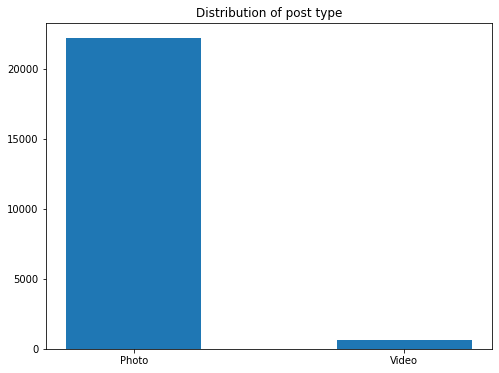

In [73]:
# visualise distribution of post type
plt.figure(figsize=(8,6))
plt.bar(['Photo', 'Video'], post_type, width=0.5)
plt.title('Distribution of post type')
plt.show()

The majority of posts are in the form of photos.

In [71]:
# obtain distribution of business account
business_acc = df_train['is_business_account'].value_counts()
business_acc 

1    13023
0     9797
Name: is_business_account, dtype: int64

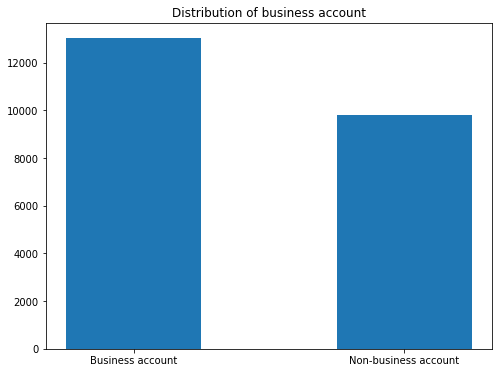

In [72]:
# visualise distribution of business account
plt.figure(figsize=(8,6))
plt.bar(['Business account', 'Non-business account'], business_acc, width=0.5)
plt.title('Distribution of business account')
plt.show()

The majority of accounts are business accounts.

### Feature engineering

Before fitting a regression model, the `post_type` column has to be one-hot encoded to be transformed into continuous variables.

In [83]:
# one-hot encode post type column
ohe = OneHotEncoder()
df_train[['is_photo', 'is_video']] = ohe.fit_transform(df_train[['post_type']]).toarray()

In [84]:
# check the one-hot encoded columns are added
df_train.head()

,post_type,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes,is_photo,is_video
sid,,,,,,,,,,,
28919418,1,78,420,594895,3612,1,2,41,4985,1.0,0.0
42114489,1,2,486,428,95,0,120,11,57,1.0,0.0
19193237,1,15,5378,36618,1259,1,11,51,1576,1.0,0.0
11733129,1,5,62,126,39,0,-118,52,29,1.0,0.0
8540244,1,11,544,45450,1251,1,30,59,1487,1.0,0.0


In [85]:
# drop post type column
df_train = df_train.iloc[:,1:]
df_train.head()

,number_comments,following,followers,n_posts,is_business_account,lng,lat,numbr_likes,is_photo,is_video
sid,,,,,,,,,,
28919418,78,420,594895,3612,1,2,41,4985,1.0,0.0
42114489,2,486,428,95,0,120,11,57,1.0,0.0
19193237,15,5378,36618,1259,1,11,51,1576,1.0,0.0
11733129,5,62,126,39,0,-118,52,29,1.0,0.0
8540244,11,544,45450,1251,1,30,59,1487,1.0,0.0


### Modelling

In [87]:
# get predictor and target variables
X = df_train[[i for i in df_train.columns if i != 'numbr_likes']]
y = df_train['numbr_likes']

print('X shape: ', X.shape)
print('y shape: ', y.shape)

X shape:  (22820, 9)
y shape:  (22820,)


In [93]:
# set seed for 5-fold cross validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

#### 1. Linear Regression

First, fit a linear regression model with all features.

In [96]:
rmse_lr = (-1 * cross_val_score(LinearRegression(), X, y, scoring='neg_root_mean_squared_error', cv=cv)).mean()
rmse_lr

15155.127498505506

Perform stepwise feature selection by removing features with the highest p-value, and verify that the AIC decreases after each step.

In [107]:
# full model
model1 = ols(
    formula='numbr_likes ~ number_comments + following + followers + n_posts + is_business_account + lng + lat + is_photo + is_video',
    data=df_train
).fit()

print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.390
Method:                 Least Squares   F-statistic:                     1828.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:00:59   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22811   BIC:                         5.003e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2212.1067    

In [108]:
# longitude removed
model2 = ols(
    formula='numbr_likes ~ number_comments + following + followers + n_posts + is_business_account + lat + is_photo + is_video',
    data=df_train
).fit()

print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     2090.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:02:03   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22812   BIC:                         5.003e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2212.4156    

In [109]:
# latitude removed
model3 = ols(
    formula='numbr_likes ~ number_comments + following + followers + n_posts + is_business_account + is_photo + is_video',
    data=df_train
).fit()

print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     2438.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:03:11   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22813   BIC:                         5.003e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2175.9749    

In [110]:
# following column removed
model4 = ols(
    formula='numbr_likes ~ number_comments + followers + n_posts + is_business_account + is_photo + is_video',
    data=df_train
).fit()

print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:            numbr_likes   R-squared:                       0.391
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     2926.
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        15:04:32   Log-Likelihood:            -2.5010e+05
No. Observations:               22820   AIC:                         5.002e+05
Df Residuals:                   22814   BIC:                         5.003e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            2173.5548    

In [111]:
# verify that AIC decreases after each step
print(model1.aic, model2.aic, model3.aic, model4.aic)

500222.50396426226 500220.546001416 500218.650894842 500216.90274529054


The features removed are `lng`, `lat`, and `following` respectively at each step. 

In [113]:
X_selected = X[['number_comments', 'followers', 'n_posts', 'is_business_account', 'is_photo', 'is_video']]

In [114]:
# fit a linear regression model with the selected features
rmse_lr_selected = (-1 * cross_val_score(LinearRegression(), X_selected, y, scoring='neg_root_mean_squared_error', cv=cv)).mean()
rmse_lr_selected

15154.407778187484

#### 2. Elastic Net

In [95]:
# scale predictors to have mean of 0 and standard deviation of 1
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X))

pd.options.display.float_format = '{:,.4f}'.format
X_std.describe().loc[['mean', 'std']]

,0,1,2,3,4,5,6,7,8
mean,0.0000,-0.0000,0.0000,0.0000,-0.0000,0.0000,0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [98]:
# define range of alphas (l1_ratio) and lambdas (alpha) to be passed to the model
l1_ratio = [.1, .3, .5, .7, .9, .95, .99, 1]
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

In [105]:
# fit the Elastic Net model by cross validation
elastic_net_model = ElasticNetCV(l1_ratio=l1_ratio, alphas=alphas, max_iter=2000)
rmse_en = (-1 * cross_val_score(elastic_net_model, X_std, y, scoring='neg_root_mean_squared_error', cv=cv)).mean()
rmse_en

15120.785235625599

### 3. Principal Component Regression (PCR)

In [120]:
# fit a PCR model to the standardised predictors
pca = PCA()
X_pc = pca.fit_transform(X_std)

In [121]:
# record mean squared error of models when including different number of principal components
lr = LinearRegression()
mse_scores = []

for i in range(1, X_pc.shape[1]+1):
    mse_scores.append(-1 * cross_val_score(lr, X_pc[:,:i], y, cv=cv, scoring='neg_mean_squared_error').mean())

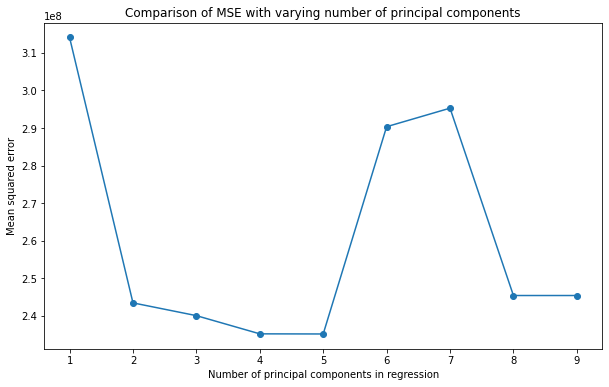

In [122]:
# visualise distribution of mean squared errors
plt.figure(figsize=(10,6))
plt.plot(mse_scores, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('Mean squared error')
plt.title('Comparison of MSE with varying number of principal components')
plt.xticks(np.arange(X_pc.shape[1]), np.arange(1, X_pc.shape[1]+1))
plt.show()

Based on the graph, the MSE declines up to 4 principal components, after which it actually increases. Hence, the model will be built with 4 principal components.

In [123]:
NUM_PC = 4
rmse_pc = (-1 * cross_val_score(LinearRegression(), X_pc[:,:NUM_PC], y, scoring='neg_root_mean_squared_error', cv=cv)).mean()
rmse_pc

15172.623667982367

## Test dataset

Now apply the same data cleaning and feature engineering steps to the test set.

### Data cleaning

In [115]:
df_test.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,location_id,profile_id,sid,sid_profile,post_id,post_type,description,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,0,6905,7115,16628794,433011845,37849814,3681636,BzGxKpjJR7O,1,When you pree her insta and she‚Äôs deleted th...,...,NaN,GB,01234 351115,False,False,Bedford International Athletic Stadium has acq...,Bedford,United Kingdom,0,52
1,1,22270,22924,13404453,28319341,38354690,3750553,By4UVohp7K3,1,Favourite yoga/ pilates/ fitness studios in Ba...,...,NaN,TH,NaN,True,False,NaN,Bangkok,Thailand,100,13
2,2,8449,8708,238342740,2280748136,14982216,3441757,BxFgEf7n7QB,1,Will never get over how beautiful this place i...,...,NaN,FO,NaN,False,False,NaN,NaN,NaN,-6,61
3,3,25778,26526,221023562,23814473,26521031,3803545,BmDEGOMAfZZ,1,Jag hann. Men det hade inte g√•tt utan min v√§...,...,NaN,SE,0647-353 00,False,False,V√•l√•dalen ligger d√§r √§ventyret b√∂rjar. H√...,NaN,NaN,12,63
4,4,26248,27010,710819371,303411945,36798813,3765067,ByUwqJMIJIv,1,–ö–æ–≥–¥–∞ —É —Ç–µ–±—è –æ–¥–Ω–∏ –ø–ª–∞–Ω—ã –Ω–...,...,NaN,RU,+7 495 937 90 40,False,False,NaN,NaN,NaN,37,55


In [116]:
df_test.shape

(5731, 32)

In [117]:
df_test.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'location_id',
       'profile_id', 'sid', 'sid_profile', 'post_id', 'post_type',
       'description', 'numbr_likes', 'number_comments', 'profile_name',
       'firstname_lastname', 'following', 'followers', 'n_posts', 'url',
       'is_business_account', 'name', 'zip', 'city', 'region', 'cd', 'phone',
       'aj_exact_city_match', 'aj_exact_country_match', 'blurb',
       'dir_city_name', 'dir_country_name', 'lat', 'lng'],
      dtype='object')

In [118]:
# remove first three unnamed columns
df_test = df_test[[col for col in df_test.columns[3:]]]
df_test.head()

,location_id,profile_id,sid,sid_profile,post_id,post_type,description,numbr_likes,number_comments,profile_name,...,region,cd,phone,aj_exact_city_match,aj_exact_country_match,blurb,dir_city_name,dir_country_name,lat,lng
0,16628794,433011845,37849814,3681636,BzGxKpjJR7O,1,When you pree her insta and she‚Äôs deleted th...,NaN,111,tj_athlete,...,NaN,GB,01234 351115,False,False,Bedford International Athletic Stadium has acq...,Bedford,United Kingdom,0,52
1,13404453,28319341,38354690,3750553,By4UVohp7K3,1,Favourite yoga/ pilates/ fitness studios in Ba...,NaN,29,madiross,...,NaN,TH,NaN,True,False,NaN,Bangkok,Thailand,100,13
2,238342740,2280748136,14982216,3441757,BxFgEf7n7QB,1,Will never get over how beautiful this place i...,NaN,67,droneofficial,...,NaN,FO,NaN,False,False,NaN,NaN,NaN,-6,61
3,221023562,23814473,26521031,3803545,BmDEGOMAfZZ,1,Jag hann. Men det hade inte g√•tt utan min v√§...,NaN,46,bingorimer,...,NaN,SE,0647-353 00,False,False,V√•l√•dalen ligger d√§r √§ventyret b√∂rjar. H√...,NaN,NaN,12,63
4,710819371,303411945,36798813,3765067,ByUwqJMIJIv,1,–ö–æ–≥–¥–∞ —É —Ç–µ–±—è –æ–¥–Ω–∏ –ø–ª–∞–Ω—ã –Ω–...,NaN,6,juliabodyul,...,NaN,RU,+7 495 937 90 40,False,False,NaN,NaN,NaN,37,55


In [124]:
df_test.sid.nunique()

5720

In [127]:
# keep relevant variables and use sid as the index column
predictors = ['sid', 'post_type', 'number_comments', 'following', 'followers', 'n_posts', 'is_business_account', 'lat', 'lng', 'numbr_likes']
df_test = df_test[[col for col in predictors]]
df_test.head()

,sid,post_type,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes
0,37849814,1,111,805,17491,257.0000,False,0,52,NaN
1,38354690,1,29,583,357246,"1,339.0000",True,100,13,NaN
2,14982216,1,67,1258,128176,"1,913.0000",True,-6,61,NaN
3,26521031,1,46,2329,172429,"8,090.0000",True,12,63,NaN
4,36798813,1,6,244,10253,511.0000,False,37,55,NaN


In [128]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5731 entries, 0 to 5730
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sid                  5731 non-null   int64  
 1   post_type            5731 non-null   int64  
 2   number_comments      5731 non-null   int64  
 3   following            5731 non-null   int64  
 4   followers            5731 non-null   int64  
 5   n_posts              5731 non-null   float64
 6   is_business_account  5731 non-null   bool   
 7   lat                  5731 non-null   int64  
 8   lng                  5731 non-null   int64  
 9   numbr_likes          0 non-null      float64
dtypes: bool(1), float64(2), int64(7)
memory usage: 408.7 KB


In [129]:
# convert is_business_account column to integers
df_test['is_business_account'] = df_test['is_business_account'].replace({True: 1, False: 0})

df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5731 entries, 0 to 5730
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sid                  5731 non-null   int64  
 1   post_type            5731 non-null   int64  
 2   number_comments      5731 non-null   int64  
 3   following            5731 non-null   int64  
 4   followers            5731 non-null   int64  
 5   n_posts              5731 non-null   float64
 6   is_business_account  5731 non-null   int64  
 7   lat                  5731 non-null   int64  
 8   lng                  5731 non-null   int64  
 9   numbr_likes          0 non-null      float64
dtypes: float64(2), int64(8)
memory usage: 447.9 KB


### Feature engineering

In [130]:
# one-hot encode post type column
ohe = OneHotEncoder()
df_test[['is_photo', 'is_video']] = ohe.fit_transform(df_test[['post_type']]).toarray()

In [133]:
# drop post type column
df_test = df_test[[i for i in df_test.columns if (i != 'sid') & (i != 'post_type')]]
df_test.head()

,number_comments,following,followers,n_posts,is_business_account,lat,lng,numbr_likes,is_photo,is_video
0,111,805,17491,257.0000,0,0,52,NaN,1.0000,0.0000
1,29,583,357246,"1,339.0000",1,100,13,NaN,1.0000,0.0000
2,67,1258,128176,"1,913.0000",1,-6,61,NaN,1.0000,0.0000
3,46,2329,172429,"8,090.0000",1,12,63,NaN,1.0000,0.0000
4,6,244,10253,511.0000,0,37,55,NaN,1.0000,0.0000


In [134]:
# get predictors
X_test = df_test[[i for i in df_test.columns if i != 'numbr_likes']]

print('X test shape: ', X_test.shape)

X test shape:  (5731, 9)


### Prediction

In [135]:
# scale predictors
scaler = StandardScaler()
X_test_std = pd.DataFrame(scaler.fit_transform(X_test))

pd.options.display.float_format = '{:,.4f}'.format
X_test_std.describe().loc[['mean', 'std']]

,0,1,2,3,4,5,6,7,8
mean,0.0000,-0.0000,-0.0000,0.0000,-0.0000,-0.0000,-0.0000,0.0000,-0.0000
std,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001,1.0001


In [136]:
y_pred = elastic_net_model.predict(X_test_std)
y_pred

NotFittedError: This ElasticNetCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.